[OSHOME](https://docs.ohsome.org/ohsome-api/v1/) is an web API which allows to analyze the history of feature objects from OpenStreetMap from 2008 on.

## Import librariers and load functions

In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.1 MB/s eta 0:00:00


In [11]:
# @title
import osmnx
import json
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import matplotlib.ticker as ticker
import ipywidgets as widgets

In [12]:
# @title
# OHSOME API plot function
def load_plot(area, URL, roads=False,ylabel="Value"):
    def inner_fetch(filter_str):
      #Set current year
      year = datetime.today().strftime('%Y')
      date = f"2008-01-01/{year}-01-01/P6M" #special query string for OHSOME: from 2007-11-01 to current date with 6 month interval
      # Fetch OHSOME API
      data = {"bpolys": area,"format": "json", "time": date, "filter": filter_str}
      response = requests.post(URL, data=data)

      #Convert result-property into list
      ls = response.json()["result"]

      # Extract time and values from the dictionaries and put into a list
      try:
        time_ls = [item['timestamp'] for item in ls]
      except:
        time_ls = [item['fromTimestamp'] for item in ls]

      value_ls = [item['value'] for item in ls]

      # Extract year and month
      time_ls = [date.split("-") for date in time_ls]
      time_ls = [f"{date[0]}-{date[1]}" for date in time_ls]

      #time_ls = [date.strftime('%Y-%m') for date in time_ls] ZIEL und TODo: in datetime format umwandeln!!!
      #print(time_ls, value_ls)

      return [time_ls, value_ls]


    # Create figure and call inner_fetch function for each querrytype to plot
    plt.figure(figsize=(12, 6))

    time_value_ls = inner_fetch(cycle_tracks)
    plt.plot(time_value_ls[0], time_value_ls[1], color='#0a007b', label='Cycle Tracks', )
    time_value_ls = inner_fetch(cycle_lanes)
    plt.plot(time_value_ls[0], time_value_ls[1], color='#006bff', label='Cycle Lanes')
    time_value_ls = inner_fetch(calm_traffic_ways)
    plt.plot(time_value_ls[0], time_value_ls[1], color='#c63ddb', label='Calm Traffic Ways')
    #if roads parameter is set, plot also main roads
    if roads:
      time_value_ls = inner_fetch(main_roads)
      plt.plot(time_value_ls[0], time_value_ls[1], color='grey', label='Main Roads')

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

    # Add labels, title and grid
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle='-', alpha=0.2)
    plt.legend()

    #only 3 subticks
    ax = plt.gca()
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(3))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(3))

    # Display the plot
    plt.show()


## Loading libraries and area of investigation file

Load area of investigation directly from OSM (via osmnx and Nominatim). Search for it like in [Nominatim](https://nominatim.openstreetmap.org/ui/search.html), for example: *Mühlau, Innsbruck, Austria*

In [5]:
# @title
query = input("Please enter the city, town or region you want to analyze: ")

Please enter the city, town or region you want to analyze: Innsbruck, Austria


{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"bbox_north": 47.3601261, "bbox_south": 47.2107727, "bbox_east": 11.4559615, "bbox_west": 11.3016374, "place_id": 63728919, "osm_type": "relation", "osm_id": 4835169, "lat": 47.2654296, "lon": 11.3927685, "class": "boundary", "type": "administrative", "place_rank": 12, "importance": 0.647185146616891, "addresstype": "city", "name": "Innsbruck", "display_name": "Innsbruck, Tyrol, Austria"}, "geometry": {"type": "Polygon", "coordinates": [[[11.3016374, 47.2704354], [11.3027735, 47.2691456], [11.3035166, 47.268302], [11.3051028, 47.2669704], [11.3051781, 47.2644328], [11.3073264, 47.2646335], [11.3102367, 47.2649017], [11.3131238, 47.2651678], [11.3132676, 47.2651689], [11.3195457, 47.2652084], [11.3213078, 47.265004], [11.3228349, 47.2645747], [11.3240214, 47.2638093], [11.3242541, 47.2636045], [11.324487, 47.263291], [11.3258916, 47.2612295], [11.3270433, 47.2601642], [11.3273126, 47.259931], [11.33

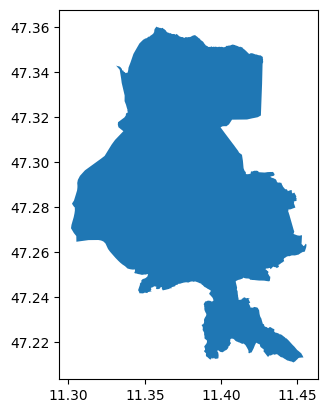

In [6]:
# @title
#Nominatim query
gdf = osmnx.geocode_to_gdf(query)
gdf.plot()

#Get the area as a GEOJSON file
areajson = gdf.to_json()
print(areajson)

Or Load it with your own GEOSON file

In [ ]:
# @title
#Load GEOJSON file for area, only if no query is not already loaded with OSMNX
if not query:
    with open("/content/ibk.geojson", encoding='utf-8') as f:
        areajson = json.load(f)
        areajson = json.dumps(areajson)

## Predefined querries for Overpass for all infrastructure classes

In [14]:
# @title
# Overpass turbo querries
cycle_tracks = "highway=cycleway or (highway=path or highway= footway) and (bicycle=designated or bicycle=yes or bicycle=permissive) or (cycleway=track or cycleway=opposite_track) or (cycleway:right=track or cycleway:right=opposite_track) or (cycleway:left=track or cycleway:left=opposite_track) or (cycleway:both=track or cycleway:both=opposite_track)"
cycle_lanes = "(cycleway=lane or cycleway=opposite_lane) or (cycleway:right=lane or cycleway:right=opposite_lane) or (cycleway:left=lane or cycleway:left=opposite_lane) or (cycleway:both=lane or cycleway:both=opposite_lane)"
calm_traffic_ways = "((highway=track or highway=service or highway=unclassified or highway=residential) and ((motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or motor_vehicle=forestry or motor_vehicle=destination or motor_vehicle=delivery) or (access=private or access=no or access=customers or access=agricultural or access=forestry or access=destination or access=delivery)) and (bicycle=designated or bicycle=yes or bicycle=permissive)) or (highway=track and (bicycle=designated or bicycle=yes or bicycle=permissive) and (motor_vehicle!=* and access!=*)) or(highway=track and (bicycle!=*) and (motor_vehicle=private or motor_vehicle=no or motor_vehicle=customers or motor_vehicle=agricultural or access=forestry or access=destination or access=delivery))"
main_roads = "highway=unclassified or highway=residential or highway=tertiary or highway=secondary"

## Final Charts over Time

For each graph, the characteristics are classified by infrastructure class. The time series runs from 2008 to the present, with values for every 6th month. If you wish, you can also plot the main traffic road features as an additional infrastructure class, to get a better comparison for the cycle-oriented infrastructure.

In [8]:
# @title
w = widgets.RadioButtons(
    options=[False, True],
#    value='pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Main roads:',
    disabled=False
)
display(w)


RadioButtons(description='Main roads:', options=(False, True), value=False)

In [9]:
print('Load main roads: ',w.value)

Load main roads:  True


### Total Amount of Features
For each class of infrastructure, time series of every 6th month up to the present.

In [13]:
load_plot(areajson, 'https://api.ohsome.org/v1/elements/count', ylabel='Amount of Features', roads=w.value)

NameError: name 'cycle_tracks' is not defined

<Figure size 1200x600 with 0 Axes>

### Length of Features
for each class of infrastructure, time series of every 6th month up to the present, in meter

In [ ]:
load_plot(areajson, 'https://api.ohsome.org/v1/elements/length', ylabel='Length of Features (in m)', roads=w.value)

### Length of Feature Density
Length of elements (in meter) divided by the total area (in square-kilometers), time series of every 6th month up to the present.

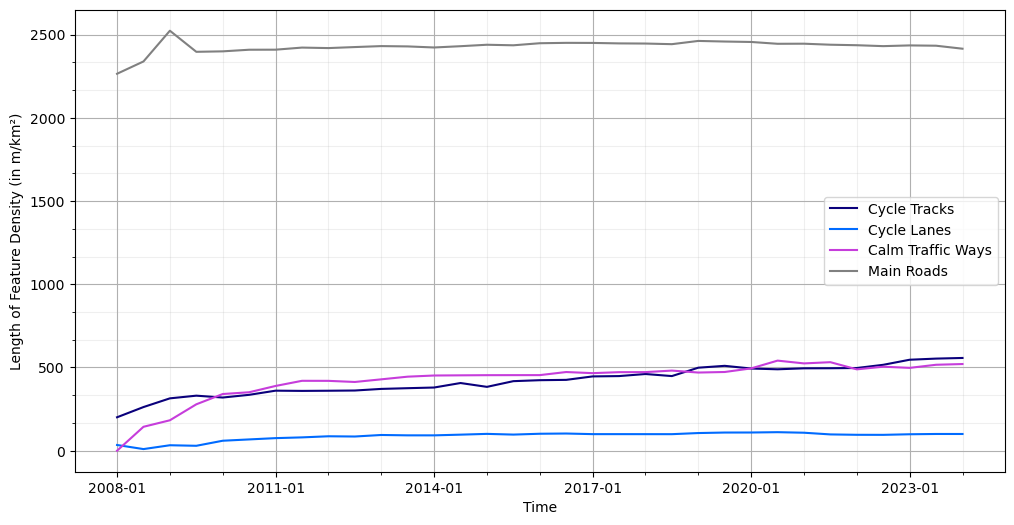

In [ ]:
load_plot(areajson, 'https://api.ohsome.org/v1/elements/length/density',  ylabel='Length of Feature Density (in m/km²)', roads=w.value)

## Contributions Count Density
Number of contributions (by OSM users) divided by the total area (in square-kilometers), time series in 6th month intervall up to present.

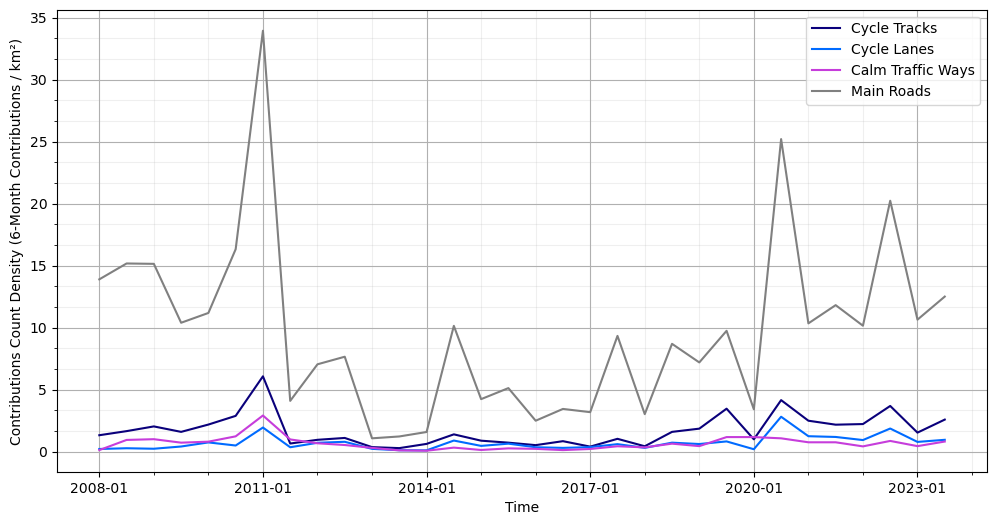

In [ ]:
load_plot(areajson, 'https://api.ohsome.org/v1/contributions/count/density', ylabel='Contributions Count Density (6-Month Contributions / km²)', roads=w.value)